test if the distribution of 

1) trip duration of bikers that ride during the day vs night

2) age of bikers for trips originating in Manhattan and in Brooklyn

are different. Use 3 tests: KS, Pearson's, Spearman's. 

Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr. 

For the KS do the test with the entire dataset and with a subset 200 times smaller

Choose a single significant threshold for the whole exercise. 

For each test phrase the Null Hypothesis in words.

Describe the return of the scipy function you use in each case.

State the result in terms of rejection of the Null.

In [69]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2017') is None:
    print ("Must set env variable PUI2017")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2017")

import os
import json

Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2017


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [70]:
os.getenv('PUIDATA')

'/home/cusp/rxl204/PUIdata'

In [71]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [72]:
df.starttime[1]

'3/1/2016 07:05:50'

In [73]:
datestring = '201603'
getCitiBikeCSV(datestring)

file in place, you can continue


In [74]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72,W 52 St & 11 Ave,40.767272,-73.993929,427,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1,2016-03-01 06:52:42
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72,W 52 St & 11 Ave,40.767272,-73.993929,254,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1,2016-03-01 07:05:50
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72,W 52 St & 11 Ave,40.767272,-73.993929,493,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2,2016-03-01 07:15:05
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1,2016-03-01 07:26:04
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72,W 52 St & 11 Ave,40.767272,-73.993929,151,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1,2016-03-01 07:31:30


# Part 1: Trip duration of bikers that rider during the day vs night

SPLIT BY DAY AND NIGHT RIDERS-looking at trip duration 

H0: there is no statistical difference in the time duration of day and night riders $$ \alpha = 0.05 $$


In [96]:
# separate the string part that indicate hours
time = lambda s:int(s[-5:-3])
daynight = lambda s:int(s[-9:-6])

# create two columns to make categories
df['time'] = df.starttime.apply(time)
df['daynight'] = df.starttime.apply(daynight)
df['daynight'].tail()

919916    17
919917    17
919918    19
919919    20
919920    20
Name: daynight, dtype: int64

In [97]:
#reassign day as 1 and night as 0 
#any time from 6am to 6pm is day, 7pm to 5am is night
df.daynight = df.daynight.replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11, 
                           12, 13, 14, 15, 16, 17, 18, 19, 20,21, 22, 23], 
                         ['0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', 
                           '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0'])
df.tail()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,time,daynight
919916,281,3/31/2016 17:23:09,3/31/2016 17:27:50,3246,Montague St & Clinton St,40.694281,-73.9923,2000,Front St & Washington St,40.702551,-73.989402,15275,Subscriber,1982.0,1,2016-03-31 17:23:09,23,1
919917,248,3/31/2016 17:39:52,3/31/2016 17:44:00,3246,Montague St & Clinton St,40.694281,-73.9923,157,Henry St & Atlantic Ave,40.690893,-73.996123,19665,Subscriber,1973.0,1,2016-03-31 17:39:52,39,1
919918,652,3/31/2016 19:52:14,3/31/2016 20:03:07,3246,Montague St & Clinton St,40.694281,-73.9923,467,Dean St & 4 Ave,40.683125,-73.978951,15230,Subscriber,1989.0,1,2016-03-31 19:52:14,52,0
919919,1794,3/31/2016 20:40:46,3/31/2016 21:10:40,3246,Montague St & Clinton St,40.694281,-73.9923,3118,McGuinness Blvd & Eagle St,40.735550,-73.952840,19752,Subscriber,1975.0,1,2016-03-31 20:40:46,40,0
919920,1188,3/31/2016 20:59:23,3/31/2016 21:19:11,3246,Montague St & Clinton St,40.694281,-73.9923,347,Greenwich St & W Houston St,40.728846,-74.008591,17288,Subscriber,1983.0,1,2016-03-31 20:59:23,59,0


In [100]:
df['dayduration'] = df['tripduration'][(df['daynight'] == '1')]
df['nightduration'] = df['tripduration'][(df['daynight'] == '0')]

In [101]:
#dropping NaN values
df['dayduration'].dropna(inplace= True)
df['nightduration'].dropna(inplace= True)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,time,daynight,dayduration,nightduration
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72,W 52 St & 11 Ave,40.767272,-73.993929,427,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1,2016-03-01 06:52:42,52,1,1491.0,NaN
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72,W 52 St & 11 Ave,40.767272,-73.993929,254,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1,2016-03-01 07:05:50,5,1,1044.0,NaN
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72,W 52 St & 11 Ave,40.767272,-73.993929,493,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2,2016-03-01 07:15:05,15,1,714.0,NaN
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1,2016-03-01 07:26:04,26,1,329.0,NaN
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72,W 52 St & 11 Ave,40.767272,-73.993929,151,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1,2016-03-01 07:31:30,31,1,1871.0,NaN


In [102]:
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,time,dayduration,nightduration
count,9.199210e+05,919921.000000,919921.000000,919921.000000,919921.000000,919921.000000,919921.000000,919921.000000,826678.000000,919921.000000,919921.000000,6.604480e+05,2.594730e+05
mean,1.019790e+03,859.263433,40.737532,-73.987185,846.843358,40.736470,-73.985822,19784.809244,1976.775033,1.103705,29.525109,1.033193e+03,9.856741e+02
std,1.011213e+04,1019.067653,0.021881,0.015512,1008.252325,0.186417,0.336602,2980.643329,11.788491,0.547556,17.280343,9.115423e+03,1.228958e+04
min,6.100000e+01,72.000000,40.678907,-74.017134,72.000000,0.000000,-74.059503,14529.000000,1885.000000,0.000000,0.000000,6.100000e+01,6.100000e+01
25%,3.640000e+02,327.000000,40.722104,-73.997901,326.000000,40.722104,-73.998102,17186.000000,NaN,1.000000,15.000000,NaN,NaN
50%,5.930000e+02,448.000000,40.739017,-73.988900,446.000000,40.738274,-73.989111,19807.000000,NaN,1.000000,30.000000,NaN,NaN
75%,1.001000e+03,521.000000,40.752062,-73.977910,520.000000,40.751873,-73.978059,22657.000000,NaN,1.000000,45.000000,NaN,NaN
max,2.825827e+06,3246.000000,40.787209,-73.929891,3246.000000,40.787209,0.000000,24773.000000,2000.000000,2.000000,59.000000,2.502192e+06,2.825827e+06


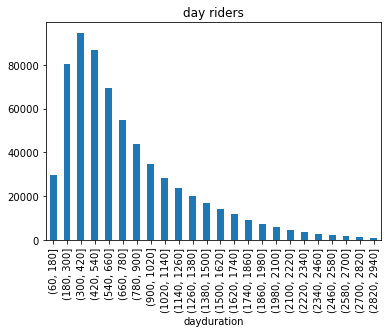

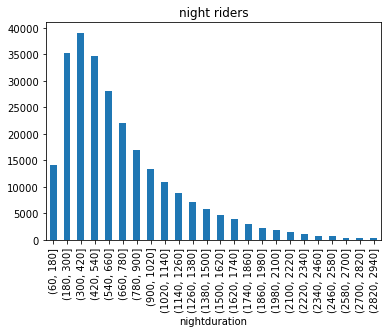

In [103]:
# plotting histograms with pandas is a bit different than with pylab
# this is a VERY USEFUL syntaxfor you to knonw!
bins = np.arange(60, 3000, 120)
axD = df.dayduration.groupby(pd.cut(df.dayduration, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False)
axD.set_title("day riders")
axN = df.nightduration.groupby(pd.cut(df.nightduration, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axN.set_title("night riders");

              count_nonzero
dayduration                
(60, 180]          0.009553
(180, 300]         0.022438
(300, 420]         0.028183
(420, 540]         0.028818
(540, 660]         0.030787
(660, 780]         0.031787
(780, 900]         0.030549
(900, 1020]        0.029240
(1020, 1140]       0.028202
(1140, 1260]       0.026106
(1260, 1380]       0.023562
(1380, 1500]       0.020365
(1500, 1620]       0.016730
(1620, 1740]       0.014000
(1740, 1860]       0.011071
(1860, 1980]       0.008696
(1980, 2100]       0.006959
(2100, 2220]       0.005482
(2220, 2340]       0.004379
(2340, 2460]       0.003093
(2460, 2580]       0.002317
(2580, 2700]       0.001280
(2700, 2820]       0.000559
(2820, 2940]       0.000000


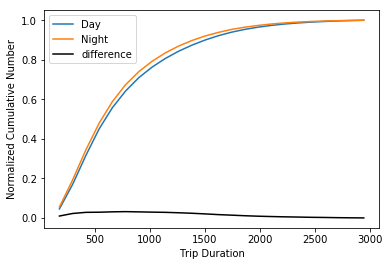

In [104]:
#cumulative sum

csD=df.dayduration.groupby(pd.cut(df.dayduration, bins)).agg([count_nonzero]).cumsum()

csN=df.nightduration.groupby(pd.cut(df.nightduration, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 120, csD / csD.max(), label = "Day")
pl.plot(bins[:-1] + 120, csN / csN.max(), label = "Night")
pl.plot(bins[:-1] + 120, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

In [105]:
import scipy.stats

KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

KS: Computes the Kolmogorov-Smirnov statistic on 2 samples.

This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution

In [106]:
ks = scipy.stats.ks_2samp(df.dayduration, df.nightduration)
print (ks)

Ks_2sampResult(statistic=0.03889225832365051, pvalue=2.6040049534824691e-245)


Answer: Since the p-value is small, we reject the null hypothesis that the trip duration for day and night riders are the same

In [252]:
#from IPython.display import Image
#Image(filename="../plotsforclasses/ks2sample_table.png")

In [112]:
len(df)

919921

In [130]:
#redo task with reduced dataset, select every 100th trip
df2 = df.iloc[::100, :]
df2.tail()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,time,daynight,dayduration,nightduration
919500,661,3/29/2016 18:27:23,3/29/2016 18:38:25,3244,University Pl & E 8 St,40.731437,-73.994903,167,E 39 St & 3 Ave,40.748901,-73.976049,19186,Subscriber,1941.0,1,2016-03-29 18:27:23,27,0,NaN,661.0
919600,1193,3/30/2016 17:05:01,3/30/2016 17:24:54,3244,University Pl & E 8 St,40.731437,-73.994903,519,Pershing Square North,40.751873,-73.977706,20835,Subscriber,1960.0,2,2016-03-30 17:05:01,5,1,1193.0,NaN
919700,963,3/31/2016 13:25:31,3/31/2016 13:41:34,3244,University Pl & E 8 St,40.731437,-73.994903,328,Watts St & Greenwich St,40.724055,-74.009660,19501,Subscriber,1975.0,1,2016-03-31 13:25:31,25,1,963.0,NaN
919800,1373,3/24/2016 14:07:46,3/24/2016 14:30:39,3246,Montague St & Clinton St,40.694281,-73.992300,365,Fulton St & Grand Ave,40.682232,-73.961458,24161,Subscriber,1975.0,1,2016-03-24 14:07:46,7,1,1373.0,NaN
919900,1268,3/30/2016 19:05:54,3/30/2016 19:27:03,3246,Montague St & Clinton St,40.694281,-73.992300,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,14935,Subscriber,1970.0,1,2016-03-30 19:05:54,5,0,NaN,1268.0


In [131]:
df2['dayduration'].dropna(inplace= True)
df2['nightduration'].dropna(inplace= True)

In [132]:
ks2 = scipy.stats.ks_2samp(df2.dayduration, df2.nightduration)
print (ks2)

Ks_2sampResult(statistic=0.041048569277102646, pvalue=0.0038145110194928392)


Answer: 
Since the p-value is below 1%, we can reject the null hypothesis. The distribution of trip duration for day and night riders are not the same. 

## Correlation

Now retest using a test for correlation.

That will answer a slightly different question though - formulate the NULL appropriately. The tests for correlations (generally) requires the variable to be paired, so that I can tell if x changes does y change similarly. But the datasets are of different size! You will need to reduce them to the same size. You can do that by subsampling of the data: take only 1 ride every of 200, which you can achieve "slicing and broadcasting" the array or using one of the python function (built in python numpy.random.choice() functions for example: Docstring: choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

    .. versionadded:: 1.7.0

Parameters ...

But make sure you understand how to use it! there is an option "replace" which you should think about.
Pearson's test for correlation¶

notice that the Pearson's is a pairwise test: the samples need to be a. the same size b. sorted! (how??)

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr


### Hypothesis
H0: There is no strong relationship between trip duration for day and night riders 

### Pearson's test for correlation
scipy.stats.pearsonr(x, y)

In [149]:
df['dayduration'].dropna(inplace= True)
df['nightduration'].dropna(inplace= True)

In [168]:
#select one trip from every 200
df3 = df[df.index % 100 == 0]
df3.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,time,daynight,dayduration,nightduration
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72,W 52 St & 11 Ave,40.767272,-73.993929,427,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1,2016-03-01 06:52:42,52,1,1491.0,NaN
100,2202,3/2/2016 11:42:06,3/2/2016 12:18:48,72,W 52 St & 11 Ave,40.767272,-73.993929,153,E 40 St & 5 Ave,40.752062,-73.981632,20508,Subscriber,1957.0,1,2016-03-02 11:42:06,42,1,2202.0,NaN
200,436,3/3/2016 10:49:45,3/3/2016 10:57:02,72,W 52 St & 11 Ave,40.767272,-73.993929,514,12 Ave & W 40 St,40.760875,-74.002777,17116,Subscriber,1974.0,1,2016-03-03 10:49:45,49,1,436.0,NaN
300,584,3/4/2016 16:22:49,3/4/2016 16:32:34,72,W 52 St & 11 Ave,40.767272,-73.993929,529,W 42 St & 8 Ave,40.757570,-73.990985,19740,Subscriber,1961.0,1,2016-03-04 16:22:49,22,1,584.0,NaN
400,1614,3/5/2016 17:56:50,3/5/2016 18:23:44,72,W 52 St & 11 Ave,40.767272,-73.993929,328,Watts St & Greenwich St,40.724055,-74.009660,22144,Customer,NaN,0,2016-03-05 17:56:50,56,1,1614.0,NaN


In [169]:
X = df3.dayduration
Y = df3.nightduration

In [170]:
pr = scipy.stats.pearsonr(X, Y)
print (pr) 

(nan, 1.0)


The results from Pearson's correlation indicates that there is no correlation in trip durations between daytime and nighttime riders. 

Pearson's correlation coefficient between two variables is defined as the covariance of the two variables divided by the product of their standard deviations.


### Spearman's test for correlation

In [173]:
spr = scipy.stats.spearmanr(X, Y)
print(spr)

SpearmanrResult(correlation=-0.61489705786805249, pvalue=0.0)


The results reveal that there is a negative correlation between trip duration for day and night riders, suggesting that longer trip duration of day time riders, the shorter the night time duration. 
However, the low p-value indicates that the probability of unrelated variables producing the same correlation is very low.
Therefore, we cannot reject the null hypothesis. 

# Part 2: Age of bikers for trips originating in Manhattan and Brooklyn

H0: there is no statistical difference in the age distribution between Mahattan and Brooklyn bikers that are subscribed to citibike
$$ \alpha = 0.05 $$

Use 3 tests: KS, Pearson's, Spearman's.

Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr.

For the KS do the test with the entire dataset and with a subset 200 times smaller

In [175]:
os.getenv('PUIDATA')

'/home/cusp/rxl204/PUIdata'

In [177]:
datestring2 = '201604'
getCitiBikeCSV(datestring2)

file in place, you can continue


In [179]:
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df2['date'] = pd.to_datetime(df2['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df2.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,496,4/1/2016 00:00:26,4/1/2016 00:08:42,254,W 11 St & 6 Ave,40.735324,-73.998004,236,St Marks Pl & 2 Ave,40.728419,-73.987140,19704,Subscriber,1984.0,1,2016-04-01 00:00:26
1,104,4/1/2016 00:00:27,4/1/2016 00:02:12,311,Norfolk St & Broome St,40.717227,-73.988021,350,Clinton St & Grand St,40.715595,-73.987030,21555,Subscriber,1970.0,1,2016-04-01 00:00:27
2,128,4/1/2016 00:00:30,4/1/2016 00:02:38,3064,Myrtle Ave & Lewis Ave,40.696820,-73.937569,3059,Pulaski St & Marcus Garvey Blvd,40.693398,-73.939877,17430,Subscriber,1986.0,1,2016-04-01 00:00:30
3,1197,4/1/2016 00:00:34,4/1/2016 00:20:31,3156,E 72 St & York Ave,40.766638,-73.953483,490,8 Ave & W 33 St,40.751551,-73.993934,17413,Subscriber,1981.0,1,2016-04-01 00:00:34
4,419,4/1/2016 00:00:46,4/1/2016 00:07:46,116,W 17 St & 8 Ave,40.741776,-74.001497,405,Washington St & Gansevoort St,40.739323,-74.008119,16714,Subscriber,1982.0,2,2016-04-01 00:00:46


In [183]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013149 entries, 0 to 1013148
Data columns (total 16 columns):
tripduration               1013149 non-null int64
starttime                  1013149 non-null object
stoptime                   1013149 non-null object
start station id           1013149 non-null int64
start station name         1013149 non-null object
start station latitude     1013149 non-null float64
start station longitude    1013149 non-null float64
end station id             1013149 non-null int64
end station name           1013149 non-null object
end station latitude       1013149 non-null float64
end station longitude      1013149 non-null float64
bikeid                     1013149 non-null int64
usertype                   1013149 non-null object
birth year                 882679 non-null float64
gender                     1013149 non-null int64
date                       1013149 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(5), object(5)
memor

In [184]:
dff = pd.concat([df, df2])
dff.info()
#join two dataframes for march and april 2016
#check if dataframes contains two months of data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2026298 entries, 0 to 1013148
Data columns (total 16 columns):
tripduration               int64
starttime                  object
stoptime                   object
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 float64
gender                     int64
date                       datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(5), object(5)
memory usage: 262.8+ MB


In [250]:
dfff = dff.assign(County="")
dfff.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,County
0,496,4/1/2016 00:00:26,4/1/2016 00:08:42,254,W 11 St & 6 Ave,40.735324,-73.998004,236,St Marks Pl & 2 Ave,40.728419,-73.987140,19704,Subscriber,1984.0,1,2016-04-01 00:00:26,
1,104,4/1/2016 00:00:27,4/1/2016 00:02:12,311,Norfolk St & Broome St,40.717227,-73.988021,350,Clinton St & Grand St,40.715595,-73.987030,21555,Subscriber,1970.0,1,2016-04-01 00:00:27,
2,128,4/1/2016 00:00:30,4/1/2016 00:02:38,3064,Myrtle Ave & Lewis Ave,40.696820,-73.937569,3059,Pulaski St & Marcus Garvey Blvd,40.693398,-73.939877,17430,Subscriber,1986.0,1,2016-04-01 00:00:30,
3,1197,4/1/2016 00:00:34,4/1/2016 00:20:31,3156,E 72 St & York Ave,40.766638,-73.953483,490,8 Ave & W 33 St,40.751551,-73.993934,17413,Subscriber,1981.0,1,2016-04-01 00:00:34,
4,419,4/1/2016 00:00:46,4/1/2016 00:07:46,116,W 17 St & 8 Ave,40.741776,-74.001497,405,Washington St & Gansevoort St,40.739323,-74.008119,16714,Subscriber,1982.0,2,2016-04-01 00:00:46,


In [251]:
lat = str(dff["start station latitude"].iloc[0])
lon =  str(dff["start station longitude"].iloc[0])
results = geolocator.reverse(lat + ", " + lon).raw
#place locations in dictionary
county = results['address']['county']
if "New York" in county:
    dfff["County"].iloc[0]=1
dfff.head()

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [248]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
for i in range(0,10):
    lat = str(dfff["start station latitude"].iloc[i])
    lon =  str(dff["start station longitude"].iloc[i])
    results = geolocator.reverse(lat + ", " + lon).raw
    #place locations in dictionary
    county = results['address']['county']
    if "New York" in county:
        dfff["County"].iloc[i]=1
    elif "Kings" in county: 
        dfff["County"].iloc[i]=0
dfff.head()

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [ ]:
# Calculate age (for subscribers only!)
dfff['ageM'] = 2015 - dfff['birth year'][(dfff['usertype'] == 'Subscriber') & (dfff['County'] == 1)]
dfff['ageB'] = 2015 - dfff['birth year'][(dfff['usertype'] == 'Subscriber') & (dfff['County'] == 0)]

In [ ]:
dfage = dfff[['ageM'],['ageB']]
dfage.head()

In [ ]:
dfage.describe()

In [ ]:
#drop null values
dfage.dropna(how='all', inplace=True)
dfage.head()

In [ ]:
ks = scipy.stats.ks_2samp(dfage.ageM, dfage.ageB)
print (ks)

In [ ]:
dfage2 = df.iloc[::200, :]
dfage2.tail()

In [ ]:
ks2 = scipy.stats.ks_2samp(dfage2.ageM, dfage2.ageB)
print (ks2)